In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv('Iphone_Sales_Data.csv')
df.head()

,Date,Model,Unnamed: 2,Month,Estimated_Units_Millions
0,10/1/2020,iPhone 12,NaN,1,0.751455
1,10/2/2020,iPhone 12,NaN,2,0.727585
2,10/3/2020,iPhone 12,NaN,3,0.776188
3,10/4/2020,iPhone 12,NaN,4,0.829549
4,10/5/2020,iPhone 12,NaN,5,0.698765


In [3]:
# Clean column names
df.columns = [col.strip() for col in df.columns]

# Keep only columns we need
df = df[['Date', 'Model', 'Month', 'Estimated_Units_Millions']].copy()

# Clean model names
df['Model'] = df['Model'].str.strip()

# Convert date
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df.head()

,Date,Model,Month,Estimated_Units_Millions
0,2020-10-01,iPhone 12,1,0.751455
1,2020-10-02,iPhone 12,2,0.727585
2,2020-10-03,iPhone 12,3,0.776188
3,2020-10-04,iPhone 12,4,0.829549
4,2020-10-05,iPhone 12,5,0.698765


In [5]:
# Create month number (days 1-30 = Month 1, 31-60 = Month 2, etc.)
def get_month_number(day):
    if day <= 30:
        return 1
    elif day <= 60:
        return 2
    elif day <= 90:
        return 3
    elif day <= 120:
        return 4
    else:
        return 5

df['Month_Num'] = df['Month'].apply(get_month_number)

# Keep only first 4 months
df_4months = df[df['Month_Num'] <= 4]

# Sum daily sales into monthly totals
monthly_sales = df_4months.groupby(['Model', 'Month_Num'])['Estimated_Units_Millions'].sum().reset_index()
monthly_sales.columns = ['Model', 'Month', 'Sales_Millions']

print(monthly_sales)

        Model  Month  Sales_Millions
0   iPhone 12      1       25.035494
1   iPhone 12      2       24.390149
2   iPhone 12      3       23.413904
3   iPhone 12      4       13.903849
4   iPhone 13      1       11.367001
5   iPhone 13      2       20.477860
6   iPhone 13      3       19.983676
7   iPhone 13      4       19.196176
8   iPhone 14      1       10.949000
9   iPhone 14      2       19.808955
10  iPhone 14      3       19.163659
11  iPhone 14      4       18.491558
12  iPhone 15      1       11.265001
13  iPhone 15      2       20.338846
14  iPhone 15      3       19.746713
15  iPhone 15      4       19.011016
16  iPhone 16      1       13.832003
17  iPhone 16      2       14.031081
18  iPhone 16      3       15.469304
19  iPhone 16      4       17.730967


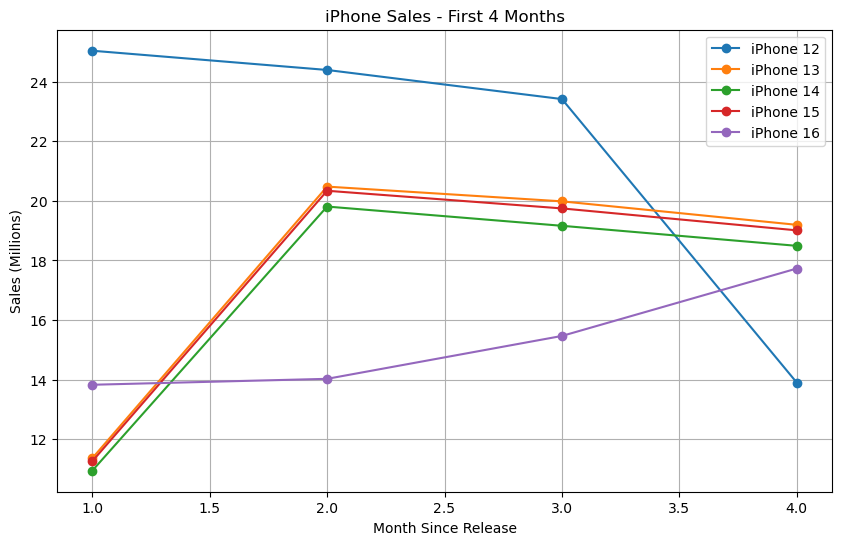

In [6]:
# Plot sales by month for each iPhone
plt.figure(figsize=(10, 6))

for model in ['iPhone 12', 'iPhone 13', 'iPhone 14', 'iPhone 15', 'iPhone 16']:
    data = monthly_sales[monthly_sales['Model'] == model]
    plt.plot(data['Month'], data['Sales_Millions'], marker='o', label=model)

plt.xlabel('Month Since Release')
plt.ylabel('Sales (Millions)')
plt.title('iPhone Sales - First 4 Months')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Add generation number (iPhone 12=0, 13=1, 14=2, 15=3, 16=4)
model_to_gen = {
    'iPhone 12': 0,
    'iPhone 13': 1,
    'iPhone 14': 2,
    'iPhone 15': 3,
    'iPhone 16': 4
}

monthly_sales['Generation'] = monthly_sales['Model'].map(model_to_gen)

# Split: Train on iPhone 12-15, Test on iPhone 16
train_data = monthly_sales[monthly_sales['Model'].isin(['iPhone 12', 'iPhone 13', 'iPhone 14', 'iPhone 15'])]
test_data = monthly_sales[monthly_sales['Model'] == 'iPhone 16']

In [8]:
# Features and target
X_train = train_data[['Generation', 'Month']]
y_train = train_data['Sales_Millions']

# Create and train model
model = LinearRegression()
model.fit(X_train, y_train)

print(f"Intercept: {model.intercept_:.2f}")
print(f"Generation coefficient: {model.coef_[0]:.2f}")
print(f"Month coefficient: {model.coef_[1]:.2f}")

Intercept: 18.40
Generation coefficient: -1.29
Month coefficient: 0.83


In [13]:
# Predict iPhone 16
X_test = test_data[['Generation', 'Month']]
predicted_16 = model.predict(X_test)
actual_16 = test_data['Sales_Millions'].values

# Compare
for i in range(4):
    error = predicted_16[i] - actual_16[i]
    pct_error = (error / actual_16[i]) * 100
    print(f"Month {i+1}: Predicted={predicted_16[i]:.2f}, Actual={actual_16[i]:.2f}, Error={pct_error:.1f}%")

# Calculate MAE and MAPE
mae = mean_absolute_error(actual_16, predicted_16)
mape = np.mean(np.abs((actual_16 - predicted_16) / actual_16)) * 100

print(f"\nMAE: {mae:.2f} million units")
print(f"MAPE: {mape:.1f}%")

Month 1: Predicted=14.05, Actual=13.83, Error=1.6%
Month 2: Predicted=14.88, Actual=14.03, Error=6.1%
Month 3: Predicted=15.71, Actual=15.47, Error=1.6%
Month 4: Predicted=16.55, Actual=17.73, Error=-6.7%

MAE: 0.63 million units
MAPE: 4.0%


In [14]:
# iPhone 17 = Generation 5
X_17 = pd.DataFrame({
    'Generation': [5, 5, 5, 5],
    'Month': [1, 2, 3, 4]
})

forecast_17 = model.predict(X_17)

print("iPhone 17 Forecast:")
print(f"  Month 1 (Oct 2025): {forecast_17[0]:.2f} million")
print(f"  Month 2 (Nov 2025): {forecast_17[1]:.2f} million")
print(f"  Month 3 (Dec 2025): {forecast_17[2]:.2f} million")
print(f"  Month 4 (Jan 2026): {forecast_17[3]:.2f} million")
print(f"  TOTAL: {sum(forecast_17):.2f} million")

iPhone 17 Forecast:
  Month 1 (Oct 2025): 12.76 million
  Month 2 (Nov 2025): 13.59 million
  Month 3 (Dec 2025): 14.42 million
  Month 4 (Jan 2026): 15.25 million
  TOTAL: 56.02 million


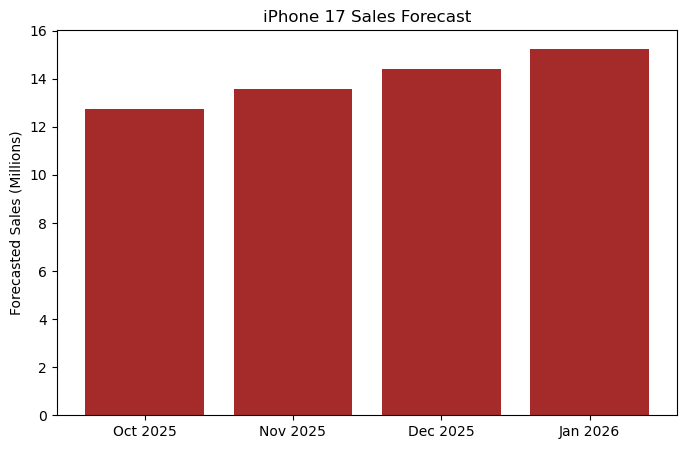

In [10]:
# Bar chart of iPhone 17 forecast
plt.figure(figsize=(8, 5))
months = ['Oct 2025', 'Nov 2025', 'Dec 2025', 'Jan 2026']
plt.bar(months, forecast_17, color='brown')
plt.ylabel('Forecasted Sales (Millions)')
plt.title('iPhone 17 Sales Forecast')
plt.show()